# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [36]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside **cs231n/classifiers/softmax.py**. 


In [38]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.323126
sanity check: 2.302585


## Inline Question 1:
Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

**Your answer:** We have 10 classes and the probabilty to be right with no prior learning is 10%

In [39]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: 0.828150 analytic: 0.828149, relative error: 2.129809e-08
numerical: -0.805791 analytic: -0.805791, relative error: 5.643412e-08
numerical: -1.089325 analytic: -1.089325, relative error: 6.320309e-08
numerical: -0.230134 analytic: -0.230134, relative error: 1.645670e-07
numerical: -2.453154 analytic: -2.453154, relative error: 7.559263e-09
numerical: 1.754663 analytic: 1.754663, relative error: 1.769240e-08
numerical: -0.203836 analytic: -0.203836, relative error: 1.088659e-07
numerical: -0.565047 analytic: -0.565047, relative error: 7.930387e-09
numerical: 0.009076 analytic: 0.009076, relative error: 2.527432e-06
numerical: -2.618099 analytic: -2.618099, relative error: 1.635720e-08
numerical: 1.837400 analytic: 1.832535, relative error: 1.325523e-03
numerical: -1.021074 analytic: -0.985685, relative error: 1.763504e-02
numerical: 0.040216 analytic: 0.038067, relative error: 2.745376e-02
numerical: -3.424590 analytic: -3.457074, relative error: 4.720372e-03
numerical: -0.81

In [40]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.323126e+00 computed in 0.104036s
vectorized loss: 2.323126e+00 computed in 0.007771s
Loss difference: 0.000000
Gradient difference: 0.000000


In [41]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None
from past.builtins import xrange
learning_rates = [1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2]
regularization_strengths = [1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 5e-2, 1e-1, 1e0, 1e1, 1e2]

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################
results = {}


for i in xrange(len(learning_rates)):
    for j in xrange(len(regularization_strengths)):
        softmax = Softmax()
        loss_hist = softmax.train(X_train, y_train, learning_rates[i], regularization_strengths[j],
                      num_iters=20000, verbose=False)
        y_train_pred = softmax.predict(X_train)
        print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
        y_val_pred = softmax.predict(X_val)
        print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))
        y_val_acc = np.mean(y_val == y_val_pred)
        y_train_acc = np.mean(y_train == y_train_pred)
        if (best_val < y_val_acc):
            best_val = y_val_acc
            print (best_val)
            best_softmax = softmax
        results[(learning_rates[i],  regularization_strengths[j])] = (y_train_acc, y_val_acc)
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

training accuracy: 0.266061
validation accuracy: 0.268000
0.268
training accuracy: 0.261163
validation accuracy: 0.269000
0.269
training accuracy: 0.263224
validation accuracy: 0.263000
training accuracy: 0.255796
validation accuracy: 0.277000
0.277
training accuracy: 0.259163
validation accuracy: 0.245000
training accuracy: 0.260612
validation accuracy: 0.264000
training accuracy: 0.268490
validation accuracy: 0.277000
training accuracy: 0.258469
validation accuracy: 0.284000
0.284
training accuracy: 0.257571
validation accuracy: 0.257000
training accuracy: 0.264408
validation accuracy: 0.274000
training accuracy: 0.262980
validation accuracy: 0.271000
training accuracy: 0.258061
validation accuracy: 0.258000
training accuracy: 0.365143
validation accuracy: 0.380000
0.38
training accuracy: 0.361816
validation accuracy: 0.359000
training accuracy: 0.365796
validation accuracy: 0.363000
training accuracy: 0.358612
validation accuracy: 0.348000
training accuracy: 0.358490
validation accu

/Users/shay-macbook/Desktop/cs231n/assignment1/cs231n/classifiers/softmax.py:63: RuntimeWarning: divide by zero encountered in log
  log_likelihood = -np.log(softmax[range(numTrain), y])


training accuracy: 0.309429
validation accuracy: 0.282000
training accuracy: 0.310061
validation accuracy: 0.279000
training accuracy: 0.327265
validation accuracy: 0.292000
training accuracy: 0.344347
validation accuracy: 0.310000
training accuracy: 0.310898
validation accuracy: 0.267000
training accuracy: 0.301143
validation accuracy: 0.247000
training accuracy: 0.316837
validation accuracy: 0.294000
training accuracy: 0.306592
validation accuracy: 0.265000
training accuracy: 0.367224
validation accuracy: 0.294000
training accuracy: 0.327878
validation accuracy: 0.273000
training accuracy: 0.412163
validation accuracy: 0.294000
training accuracy: 0.386796
validation accuracy: 0.317000


/Users/shay-macbook/Desktop/cs231n/assignment1/cs231n/classifiers/softmax.py:72: RuntimeWarning: overflow encountered in double_scalars
  loss += reg * np.sum(W * W)
/Users/shay-macbook/Desktop/cs231n/assignment1/cs231n/classifiers/softmax.py:72: RuntimeWarning: overflow encountered in multiply
  loss += reg * np.sum(W * W)


training accuracy: 0.344694
validation accuracy: 0.320000
training accuracy: 0.362653
validation accuracy: 0.334000
training accuracy: 0.303347
validation accuracy: 0.278000
training accuracy: 0.279939
validation accuracy: 0.255000
training accuracy: 0.332653
validation accuracy: 0.305000
training accuracy: 0.276980
validation accuracy: 0.254000
training accuracy: 0.349082
validation accuracy: 0.297000
training accuracy: 0.348245
validation accuracy: 0.299000
training accuracy: 0.374245
validation accuracy: 0.299000
training accuracy: 0.419755
validation accuracy: 0.309000
training accuracy: 0.396796
validation accuracy: 0.314000
training accuracy: 0.364490
validation accuracy: 0.337000


/Users/shay-macbook/Desktop/cs231n/assignment1/cs231n/classifiers/softmax.py:61: RuntimeWarning: overflow encountered in subtract
  softmax = np.exp(score - np.max(score, axis=1, keepdims=True))
/Users/shay-macbook/Desktop/cs231n/assignment1/cs231n/classifiers/softmax.py:61: RuntimeWarning: invalid value encountered in subtract
  softmax = np.exp(score - np.max(score, axis=1, keepdims=True))


training accuracy: 0.100265
validation accuracy: 0.087000
training accuracy: 0.345204
validation accuracy: 0.268000
training accuracy: 0.314755
validation accuracy: 0.260000
training accuracy: 0.303327
validation accuracy: 0.264000
training accuracy: 0.360224
validation accuracy: 0.302000
training accuracy: 0.371531
validation accuracy: 0.302000
training accuracy: 0.393510
validation accuracy: 0.305000
training accuracy: 0.412878
validation accuracy: 0.285000
training accuracy: 0.400061
validation accuracy: 0.300000
training accuracy: 0.394592
validation accuracy: 0.322000
training accuracy: 0.363939
validation accuracy: 0.332000
training accuracy: 0.100265
validation accuracy: 0.087000
training accuracy: 0.100265
validation accuracy: 0.087000
lr 1.000000e-08 reg 1.000000e-05 train accuracy: 0.266061 val accuracy: 0.268000
lr 1.000000e-08 reg 5.000000e-05 train accuracy: 0.261163 val accuracy: 0.269000
lr 1.000000e-08 reg 1.000000e-04 train accuracy: 0.263224 val accuracy: 0.263000
lr 

In [44]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.383000


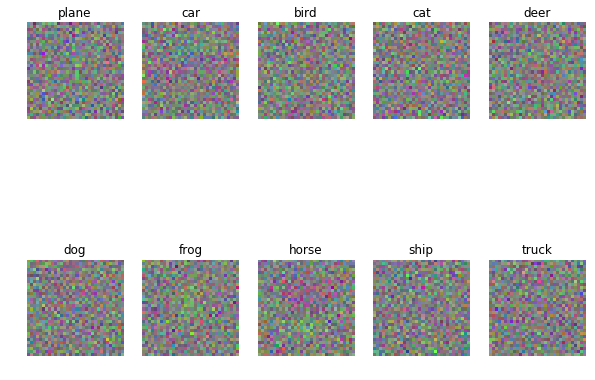

In [45]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])